In [1]:
# Plot the verification against reanalysis data (for ERA5 only):
# Plot normalized 'drmse' in lat-height coordinate
# initial built: 2024/09/05
# modified : 2024/09/25
# modified: 2024/10/02: compare drmse and exp diff in the same plot
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc

In [21]:
datahome    = '/scratch2/GFDL/gfdlscr/Chih-Chi.Hu/GribDiag/ush/plotgribnc/data/gribnc'

timerange = '2022061500_2022073000_12'
#dirname   = 'ctrl_amsua_ch5-only_clr_clr-only_clr_clr_ng-clr_and_cld_0.05-clr_and_cld_0.05_ng'
#dirname  = 'ctrl_amsua_ch5-only_clr_clr-clr_and_cld_0.05-clr_and_cld_0.05_sym-clr_and_cld_0.05_model-clr_and_cld_0.05_obs'
#dirname = 'ctrl-ctrl_noinf'
#dirname = 'ctrl-ctrl_noinf-only_clr_clr-clr_and_cld_0.05-clr_and_cld_0.05_sym-clr_and_cld_0.05_model-clr_and_cld_0.05_obs'
#dirname = 'old_ctrl-full_ctrl'
#dirname = 'full_ctrl-full_ctrl_noinf'
dirname = 'full_ctrl-full_only_clr-full_clr_cld-full_sym-full_model-full_obs'

exps      = dirname.split('-')
expref    = exps[0]

ncdir = os.path.join(datahome,'ERA5', timerange,dirname)

In [22]:
exps

['full_ctrl',
 'full_only_clr',
 'full_clr_cld',
 'full_sym',
 'full_model',
 'full_obs']

In [23]:
# read netcdfs:

dq_norm={}; dt_norm={}; dc_norm={};  # normalized error relative to exps[0]
dq={}; dt={}; dc={};                 # absolute error relative to ERA5
q={}; t={}; c={};                    # forecast mean
s95_q={}; s95_t={}; s95_c={}; 

# normalized error and significant levels:
for exp in exps:
    if exp != expref: 
        # normalized relative error
        f = nc.Dataset(f"{ncdir}/dzmean_rmse_{exp}_f06.nc")
        lat = f.variables['latitude'][:]
        lev = f.variables['level'][:]
        dq_norm[exp] = f.variables['q'][:]
        dt_norm[exp] = f.variables['t'][:]
        dc_norm[exp] = f.variables['clwmr'][:]    

        d95 = nc.Dataset(f"{ncdir}/d95_{exp}_f06.nc")
        d95_q = d95.variables['q'][:]
        d95_t = d95.variables['t'][:]
        d95_c = d95.variables['clwmr'][:]    

        s95_q[exp] = np.abs(d95_q/dq_norm[exp])>1.0
        s95_t[exp] = np.abs(d95_t/dt_norm[exp])>1.0
        s95_c[exp] = np.abs(d95_c/dc_norm[exp])>1.0  

    # absolute error
    f = nc.Dataset(f"{ncdir}/zmean_rmse_{exp}_f06.nc")
    dq[exp] = f.variables['q'][:]
    dt[exp] = f.variables['t'][:]
    dc[exp] = f.variables['clwmr'][:]    

    # forecast mean 
    f = nc.Dataset(f"{ncdir}/fcst_mean_{exp}_f06.nc")
    q[exp] = f.variables['q'][:]
    t[exp] = f.variables['t'][:]
    c[exp] = f.variables['clwmr'][:] 

In [15]:
lev

masked_array(data=[ 100,  150,  200,  250,  300,  350,  400,  450,  500,
                    550,  600,  650,  700,  750,  800,  825,  850,  875,
                    900,  925,  950,  975, 1000],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [24]:
# calculate the zonal average for forecast mean:
tz={}; qz={}; cz={};
for exp in exps:
    tz[exp] = np.mean(t[exp], axis=2)
    qz[exp] = np.mean(q[exp], axis=2)
    cz[exp] = np.mean(c[exp], axis=2)

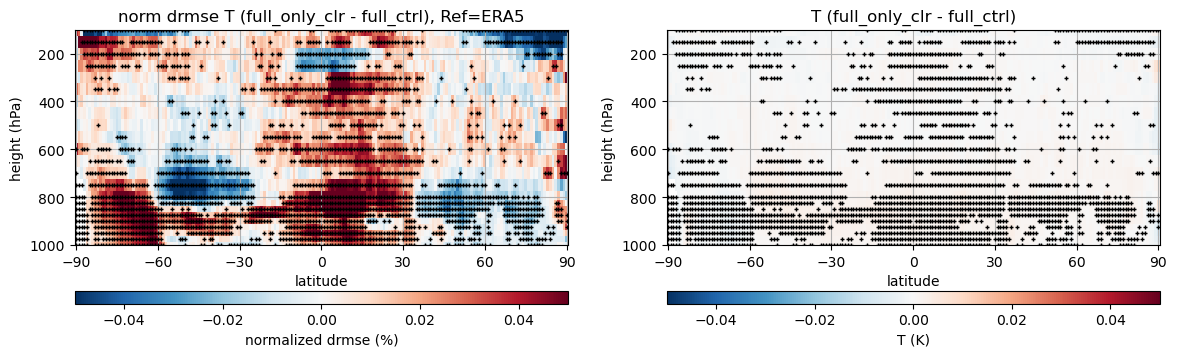

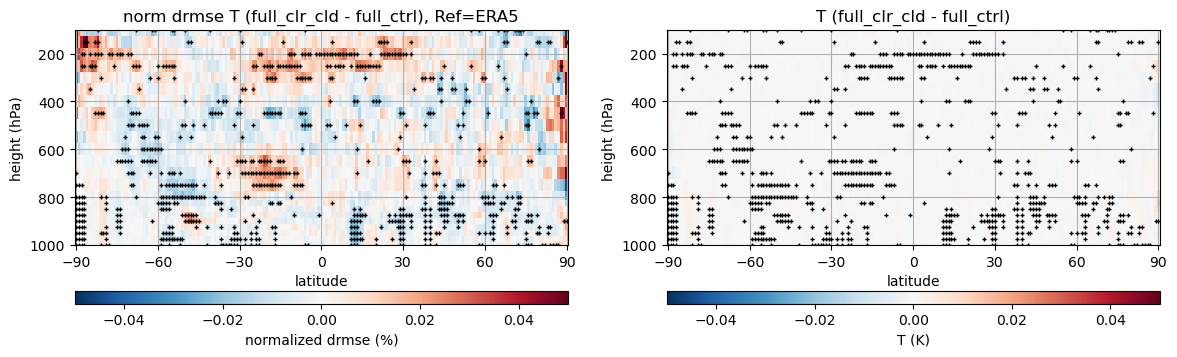

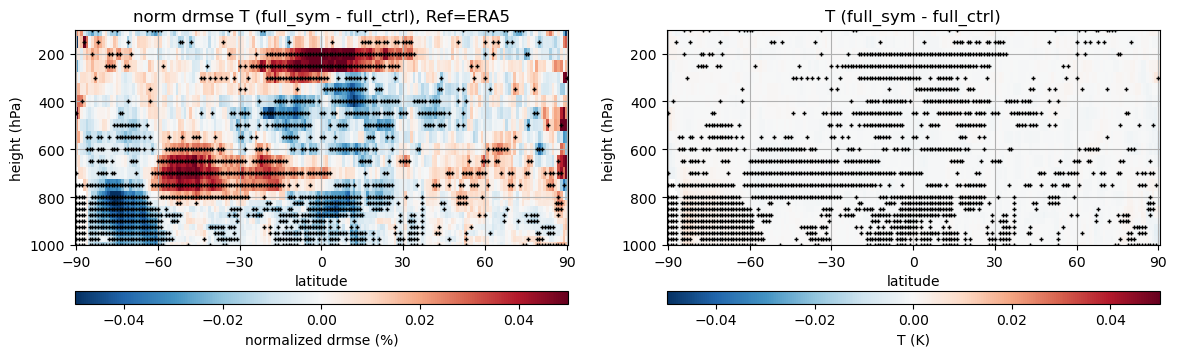

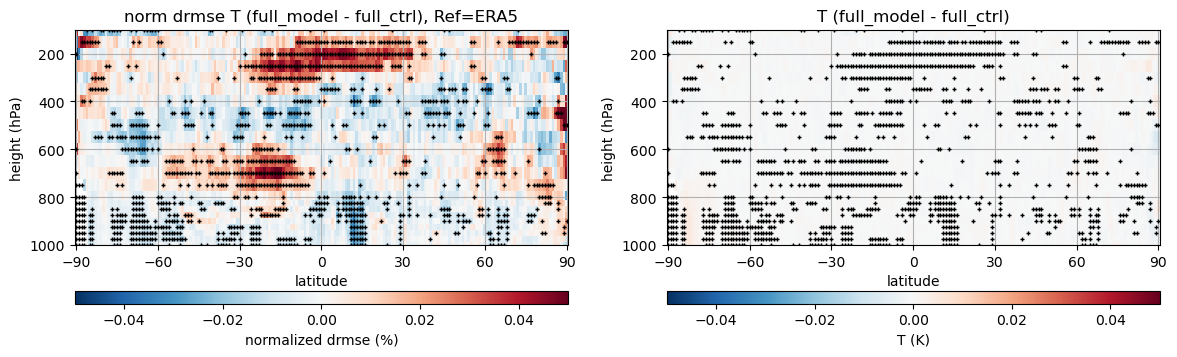

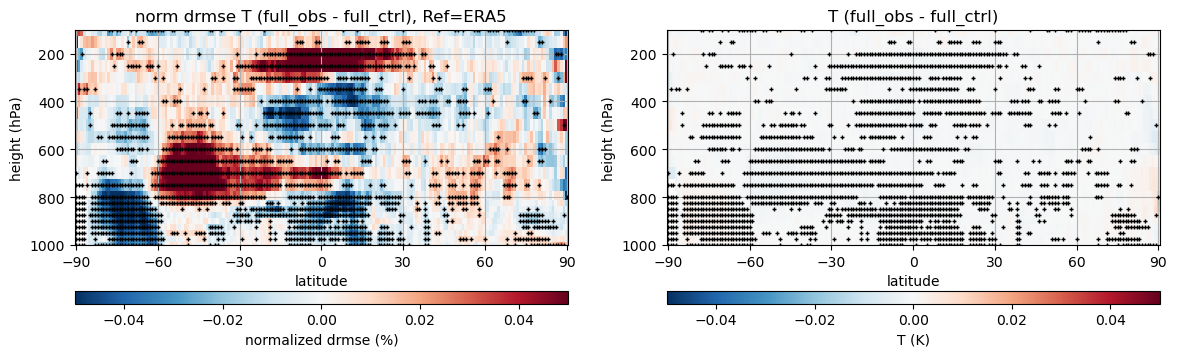

In [25]:
# Temperature:

for exptest in exps[1:]:
#exptest   = 'clr_and_cld_0.05'

    lats, levs = np.meshgrid(lat, lev)

    # normalized temperature
    vmin_norm = -0.05
    vmax_norm =  0.05

    # absolute temperature
    vmin_abs = -0.05
    vmax_abs =  0.05

    # Main Plot section:

    # figure size:
    fig = plt.figure(figsize=(14,4))

    # define the subplots
    ax1 = fig.add_subplot(1, 2, 1)  # Add subplot at position 1
    ax2 = fig.add_subplot(1, 2, 2)  # Add subplot at position 2

    # ax1: normalized error
    contour1=ax1.pcolormesh(lats, levs, dt_norm[exptest], cmap='RdBu_r', vmin=vmin_norm, vmax=vmax_norm)
    ax1.invert_yaxis()
    ax1.plot(np.ma.array(lats, mask=s95_t[exptest]), levs, 'k+', ms=2.5)
    ax1.set_xlabel('latitude')
    ax1.set_xticks([-90,-60,-30,0,30,60,90])

    ax1.set_ylabel('height (hPa)')
    ax1.set_title(f'norm drmse T ({exptest} - {expref}), Ref=ERA5')
    ax1.set_ylim(1000,100)
    ax1.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour1,location='bottom',aspect=40)
    cbar.set_label('normalized drmse (%)')

    # ax2: experiment difference
    contour2 = ax2.pcolormesh(lats, levs, tz[exptest] - tz[expref], cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
    ax2.invert_yaxis()
    ax2.plot(np.ma.array(lats, mask=s95_t[exptest]), levs, 'k+', ms=2.5)
    ax2.set_xlabel('latitude')
    ax2.set_xticks([-90,-60,-30,0,30,60,90])
    ax2.set_ylabel('height (hPa)')
    ax2.set_title(f'T ({exptest} - {expref})')
    ax2.set_ylim(1000,100)
    ax2.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour2,location='bottom',aspect=40)
    cbar.set_label('T (K)')    
    
    
    '''
    # ax2: absoulte error
    contour2 = ax2.pcolormesh(lats, levs, dt[exptest] - dt[expref], cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
    ax2.invert_yaxis()
    ax2.plot(np.ma.array(lats, mask=s95_t[exptest]), levs, 'k+', ms=2.5)
    ax2.set_xlabel('latitude')
    ax2.set_xticks([-90,-60,-30,0,30,60,90])

    ax2.set_ylabel('height (hPa)')
    ax2.set_title(f'drmse T ({exptest} - {expref}), Ref=ERA5')
    ax2.set_ylim(1000,10)
    ax2.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour2,location='bottom',aspect=40)
    cbar.set_label('drmse (K)')
    '''
    
    plt.savefig(f"ERA5_drmse_and_expdiff_T_{exptest}.png")
    plt.show()

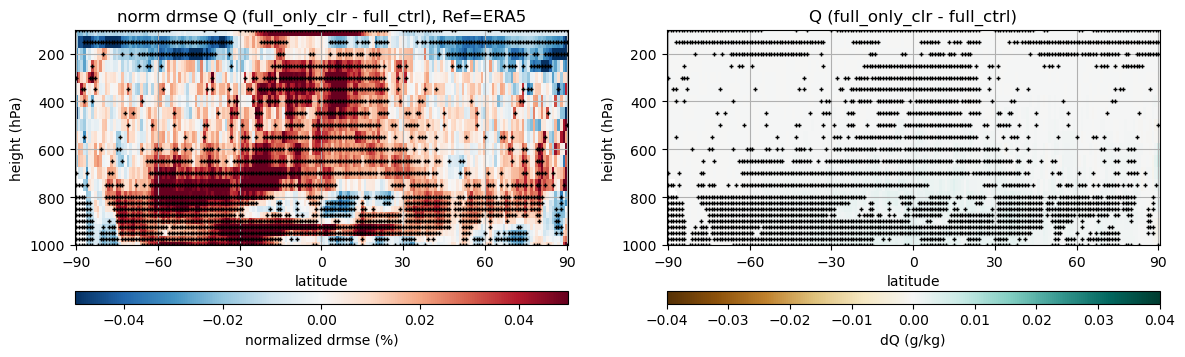

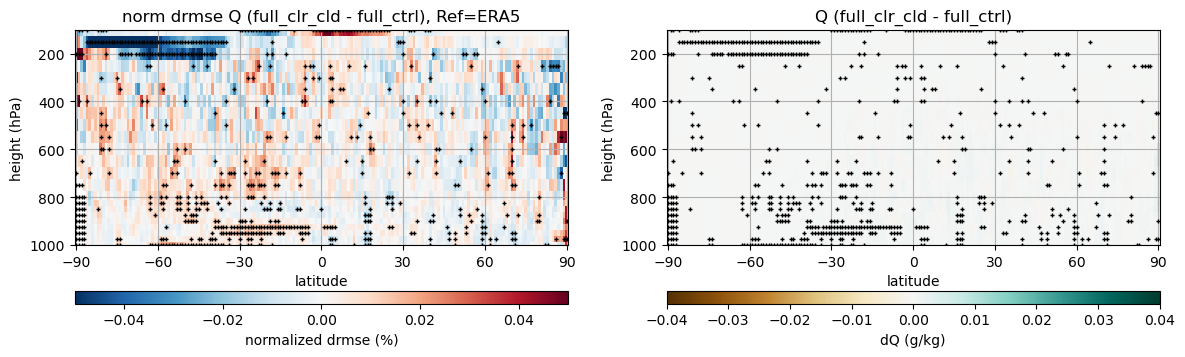

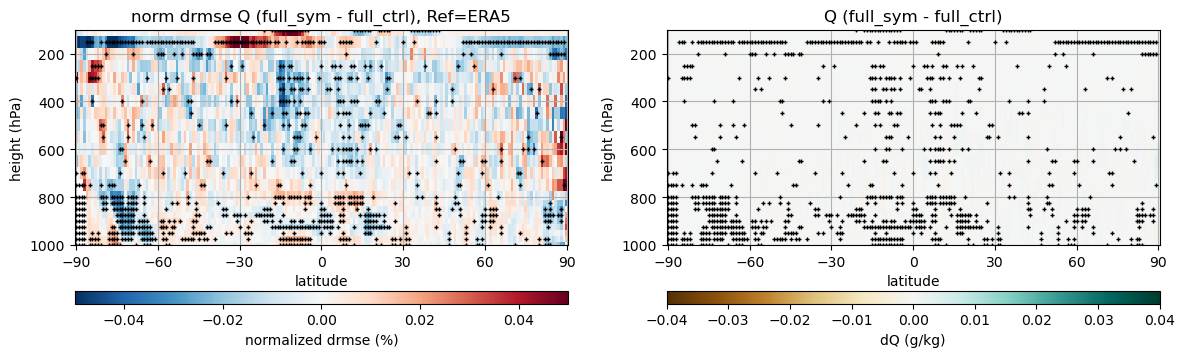

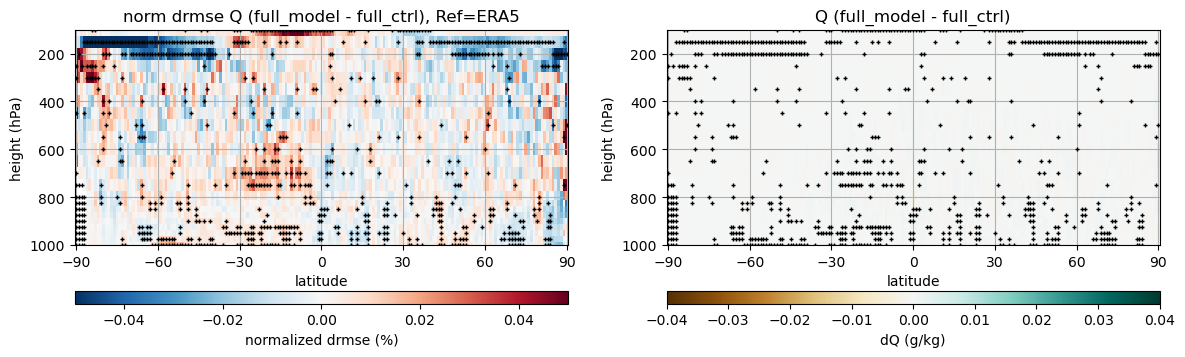

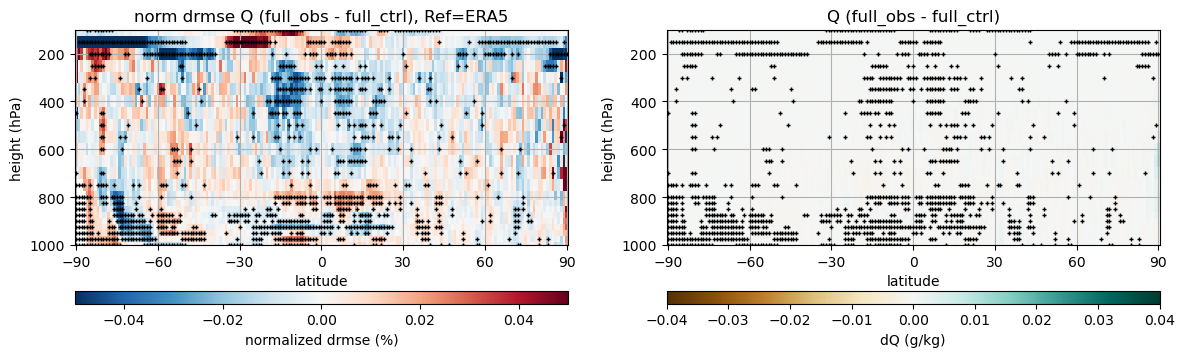

In [26]:
# Humidity:

for exptest in exps[1:]:

    lats, levs = np.meshgrid(lat, lev)

    # normalized relative humidity
    vmin_norm = -0.05
    vmax_norm =  0.05

    # absolute humidity
    vmin_abs = -0.04
    vmax_abs =  0.04

    # Main Plot section:

    # figure size:
    fig = plt.figure(figsize=(14,4))

    # define the subplots
    ax1 = fig.add_subplot(1, 2, 1)  # Add subplot at position 1
    ax2 = fig.add_subplot(1, 2, 2)  # Add subplot at position 2

    # ax1: normalized error
    contour1=ax1.pcolormesh(lats, levs, dq_norm[exptest], cmap='RdBu_r', vmin=vmin_norm, vmax=vmax_norm)
    ax1.invert_yaxis()
    ax1.plot(np.ma.array(lats, mask=s95_q[exptest]), levs, 'k+', ms=2.5)
    ax1.set_xlabel('latitude')
    ax1.set_xticks([-90,-60,-30,0,30,60,90])
    ax1.set_ylabel('height (hPa)')
    ax1.set_title(f'norm drmse Q ({exptest} - {expref}), Ref=ERA5')
    ax1.set_ylim(1000,100)
    ax1.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour1,location='bottom',aspect=40)
    cbar.set_label('normalized drmse (%)')
    
    '''
    # ax2: absoulte error
    contour2 = ax2.pcolormesh(lats, levs, (dq[exptest] - dq[expref])*1e3, cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
    ax2.invert_yaxis()
    ax2.plot(np.ma.array(lats, mask=s95_q[exptest]), levs, 'k+', ms=2.5)
    ax2.set_xlabel('latitude')
    ax2.set_ylabel('height (hPa)')
    ax2.set_title(f'drmse Q ({exptest} - {expref}), Ref=ERA5')
    ax2.set_ylim(1000,10)
    ax2.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour2,location='bottom',aspect=40)
    cbar.set_label('drmse (g/kg)')
    '''

    # ax2: experiment difference
    contour2 = ax2.pcolormesh(lats, levs, (qz[exptest] - qz[expref])*1e3, cmap='BrBG', vmin=vmin_abs, vmax=vmax_abs)
    ax2.invert_yaxis()
    ax2.plot(np.ma.array(lats, mask=s95_q[exptest]), levs, 'k+', ms=2.5)
    ax2.set_xlabel('latitude')
    ax2.set_xticks([-90,-60,-30,0,30,60,90])
    ax2.set_ylabel('height (hPa)')
    ax2.set_title(f'Q ({exptest} - {expref})')
    ax2.set_ylim(1000,100)
    ax2.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour2,location='bottom',aspect=40)
    cbar.set_label('dQ (g/kg)')
    
    plt.savefig(f"ERA5_drmse_and_expdiff_Q_{exptest}.png")
    plt.show()


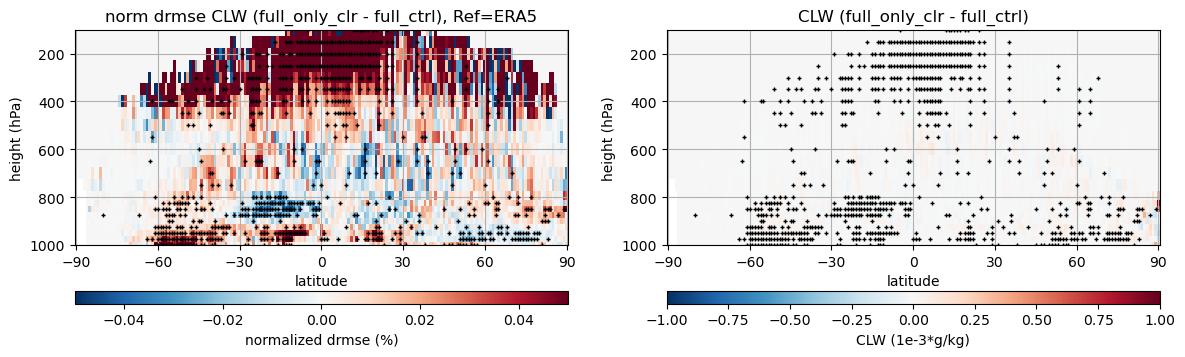

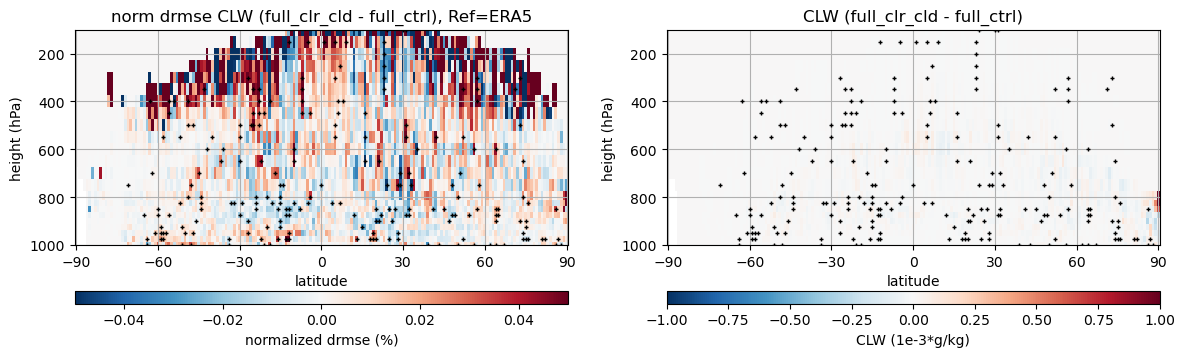

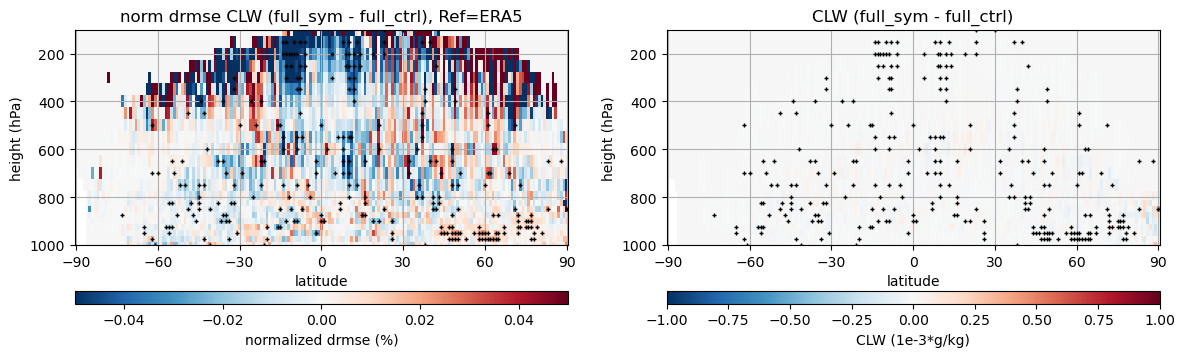

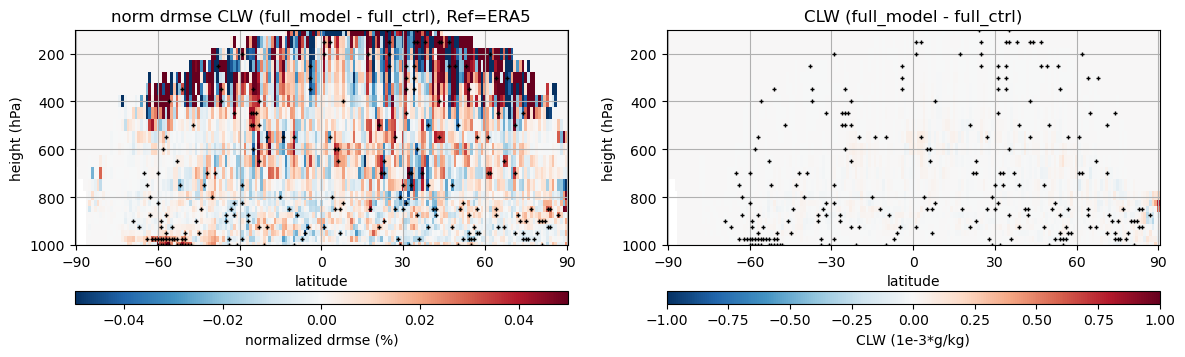

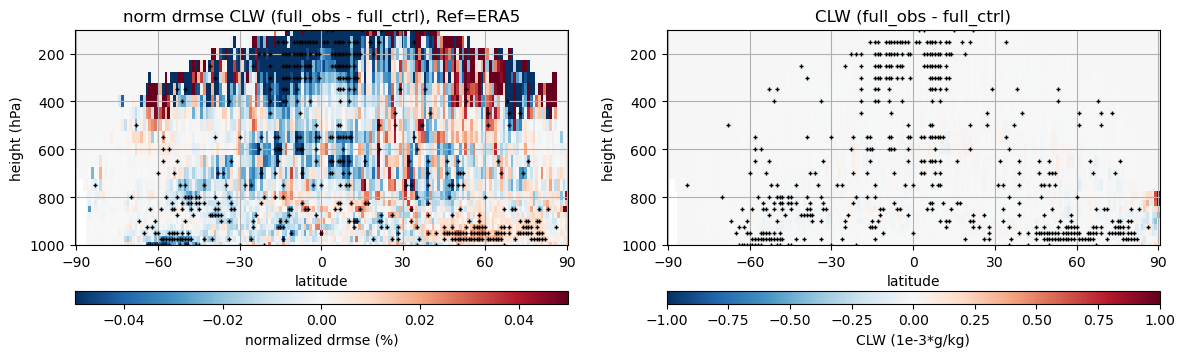

In [27]:
# CLW:

for exptest in exps[1:]:

    lats, levs = np.meshgrid(lat, lev)

    # normalized CLW
    vmin_norm = -0.05
    vmax_norm =  0.05

    # absolute humidity
    vmin_abs = -1
    vmax_abs =  1

    # Main Plot section:

    # figure size:
    fig = plt.figure(figsize=(14,4))

    # define the subplots
    ax1 = fig.add_subplot(1, 2, 1)  # Add subplot at position 1
    ax2 = fig.add_subplot(1, 2, 2)  # Add subplot at position 2

    # ax1: normalized error
    contour1=ax1.pcolormesh(lats, levs, dc_norm[exptest], cmap='RdBu_r', vmin=vmin_norm, vmax=vmax_norm)
    ax1.invert_yaxis()
    ax1.plot(np.ma.array(lats, mask=s95_c[exptest]!=False), levs, 'k+', ms=2.5)
    ax1.set_xlabel('latitude')
    ax1.set_xticks([-90,-60,-30,0,30,60,90])
    ax1.set_ylabel('height (hPa)')
    ax1.set_title(f'norm drmse CLW ({exptest} - {expref}), Ref=ERA5')
    ax1.set_ylim(1000,100)
    ax1.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour1,location='bottom',aspect=40)
    cbar.set_label('normalized drmse (%)')
    
    '''
    # ax2: absoulte error
    contour2 = ax2.pcolormesh(lats, levs, (dc[exptest] - dc[expref])*1e6, cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
    ax2.invert_yaxis()
    ax2.plot(np.ma.array(lats, mask=s95_c[exptest]), levs, 'k+', ms=2.5)
    ax2.set_xlabel('latitude')
    ax2.set_ylabel('height (hPa)')
    ax2.set_title(f'drmse Q ({exptest} - {expref}), Ref=ERA5')
    ax2.set_ylim(1000,10)
    ax2.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour2,location='bottom',aspect=40)
    cbar.set_label('drmse (1e-3*g/kg)')
    '''
    
    # ax2: experiment difference
    contour2 = ax2.pcolormesh(lats, levs, (cz[exptest] - cz[expref])*1e6, cmap='RdBu_r', vmin=vmin_abs, vmax=vmax_abs)
    ax2.invert_yaxis()
    ax2.plot(np.ma.array(lats, mask=s95_c[exptest]!=False), levs, 'k+', ms=2.5)
    ax2.set_xlabel('latitude')
    ax2.set_xticks([-90,-60,-30,0,30,60,90])
    ax2.set_ylabel('height (hPa)')
    ax2.set_title(f'CLW ({exptest} - {expref})')
    ax2.set_ylim(1000,100)
    ax2.grid(True)
    # set colorbar
    cbar = fig.colorbar(contour2,location='bottom',aspect=40)
    cbar.set_label('CLW (1e-3*g/kg)')   
    plt.savefig(f"ERA5_drmse_and_expdiff_CLW_{exptest}.png")
    plt.show()

In [42]:
s95_c[exptest]!=False

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [True, True, True, ..., --, --, --],
        [True, True, True, ..., --, --, --],
        [True, True, True, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=True)